# Project 4: Starter

### Galina Solovyeva

In this project, you will combine and apply your knowledge from all three past unit projects to create a complete data science workflow on a new dataset. We will use the Kaggle Titanic competition dataset for this project.

In [448]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import grid_search
from sklearn import metrics
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

![](../assets/images/workflow/data-science-workflow-01.png)

## Part 1. Identify the Problem

Using the competition description on [Kaggle](https://www.kaggle.com/c/titanic), write a short paragraph summarizing the problem, your goals and hypothesis.

**NOTE**: This section can be less rigorous for a kaggle competition where the problem, goals, and hypothesis are identified for you.

**Problem**: Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

**Goals**: Complete analysis of the Titanic dataset to identify what sorts of people were likely to survive.

**Hypothesis**: Certain groups of people to include women and upper-class were more likely to survive the Titanic shipwreck.

![](../assets/images/workflow/data-science-workflow-02.png)

## Part 2. Acquire the Data

Kaggle has provided two files for this dataset:  
_train.csv_: Use for building a model (contains target variable "Survived")  
_test.csv_: Use for submission file (fill in for target variable "Survived")

Both files have been downloaded and added to your datasets folder. Read the files into a Pandas DataFrame.

**HINT**: You can further split _train.csv_ to generate your own cross validation set. However, use all of _train.csv_ to train your final model since Kaggle has already separated the test set for you.

In [449]:
# Load data
df = pd.read_csv("../assets/datasets/titanic/train.csv")

# Check head
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


![](../assets/images/workflow/data-science-workflow-03-05.png)

## Part 3. Parse, Mine, and Refine the data

Perform exploratory data analysis and verify the quality of the data.

### Check columns and counts to drop any non-generic or near-empty columns

In [450]:
# Check columns
df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [451]:
# Check counts
print df.shape

(891, 12)


In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Check for missing values and drop or impute

In [453]:
# Check counts for missing values in each column
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [316]:
sum(df.isnull().values.ravel())

866

### Write a function to wrangle the data to address any issues from above checks

In [454]:
def wrangler(df):
    # Drop non-generic columns PassengerId, Name, Ticket, and near-empty column Cabin
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    # Replace missing values for age using median value
    df.Age = df['Age'].fillna(df.Age.median())
    
    # Replace missing values for Fare using median value (there are some missing in Kaggle's test set)
    df.Fare = df['Fare'].fillna(df.Fare.median())
    
    # Replace missing values for embarked using mode value
    df.Embarked = df['Embarked'].fillna(df.Embarked.mode()[0])
    
    return df

In [455]:
# Apply wrangler() to DF
df = wrangler(df)

# Check data
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [456]:
df.isnull().sum().sum()

0L

### Perform exploratory data analysis

In [457]:
# Get summary statistics for data
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


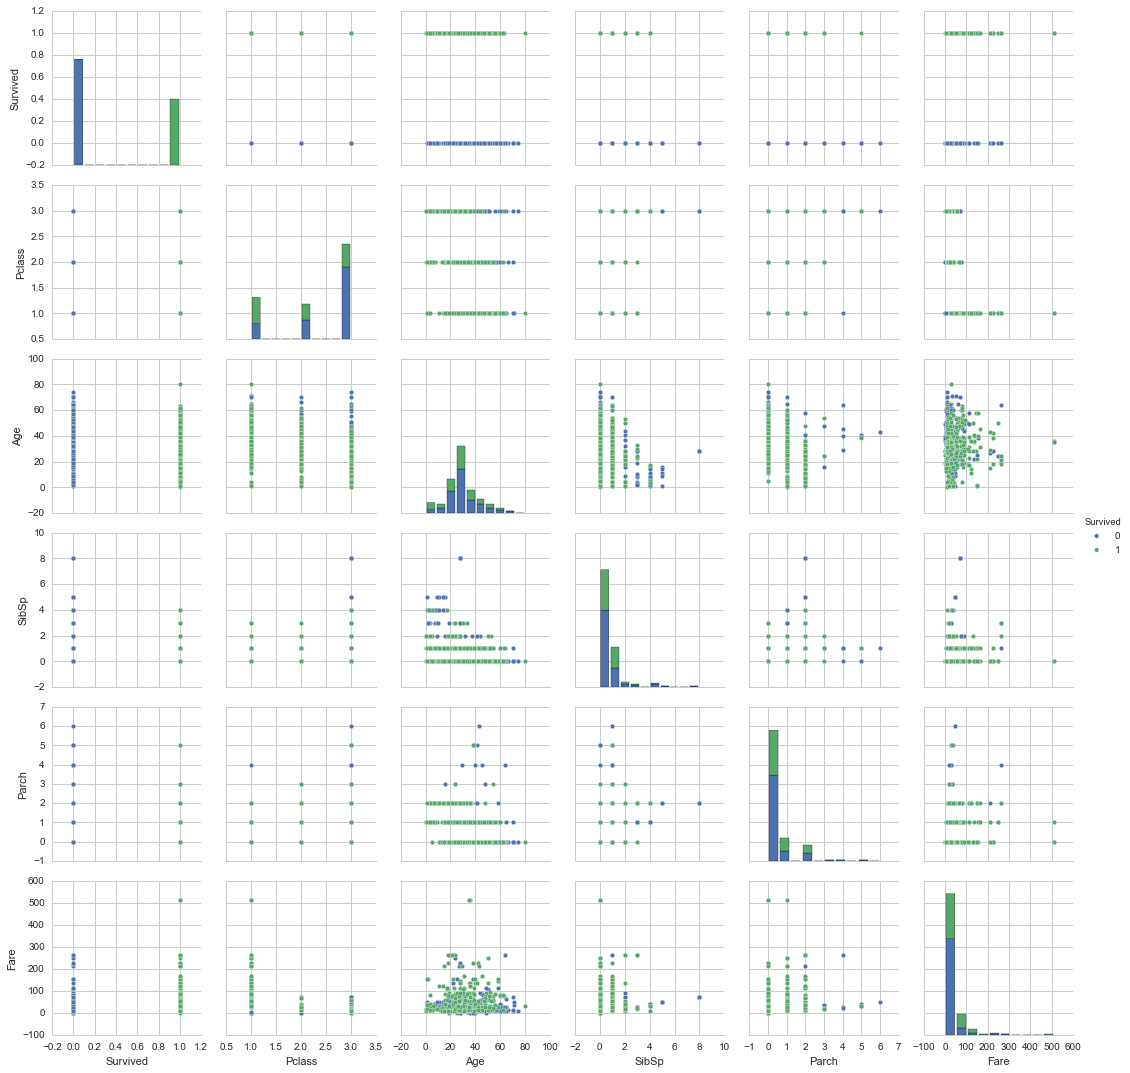

In [321]:
# Get pair plot for data
sns.pairplot(df, hue='Survived')

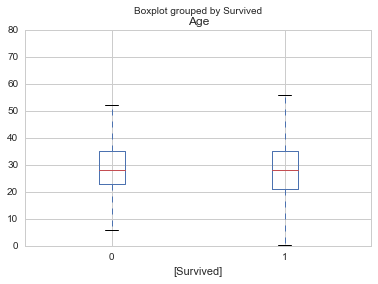

In [373]:
df[['Age','Survived']].boxplot(by="Survived")

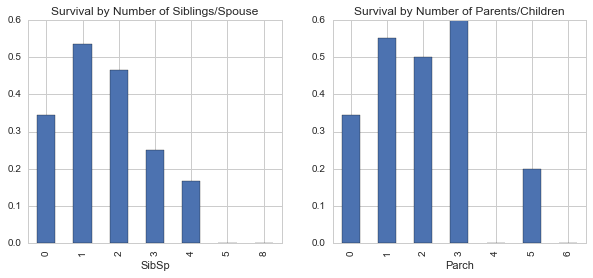

In [463]:
fig1 = plt.figure(figsize=(10,4))
ax11 = fig1.add_subplot(121)
df.groupby('SibSp').Survived.mean().plot(ax=ax11, kind='bar', title='Survival by Number of Siblings/Spouse')
ax22 = fig1.add_subplot(122)
df.groupby('Parch').Survived.mean().plot(ax=ax22, kind='bar', title='Survival by Number of Parents/Children')

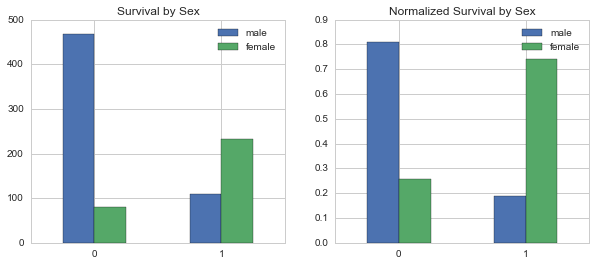

In [464]:
# Analyze Unnormalized and Normalized Survival by Sex

# Get group by counts for Unnormalized Survival by Sex
df_by_sex_unnorm = pd.DataFrame()
df_by_sex_unnorm['male'] = df[df['Sex']=='male']['Survived'].value_counts()
df_by_sex_unnorm['female'] = df[df['Sex']=='female']['Survived'].value_counts()

# Get group by counts for Normalized Survival by Sex
df_by_sex_normed = pd.DataFrame()
df_by_sex_normed['male'] = df[df['Sex']=='male']['Survived'].value_counts(normalize=True)
df_by_sex_normed['female'] = df[df['Sex']=='female']['Survived'].value_counts(normalize=True)

# Plot Unnormalized and Normalized Survival by Sex
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
df_by_sex_unnorm.plot(ax=ax1, kind='bar', rot=0, title="Survival by Sex")
ax2 = fig.add_subplot(122)
df_by_sex_normed.plot(ax=ax2, kind='bar', rot=0, title="Normalized Survival by Sex")

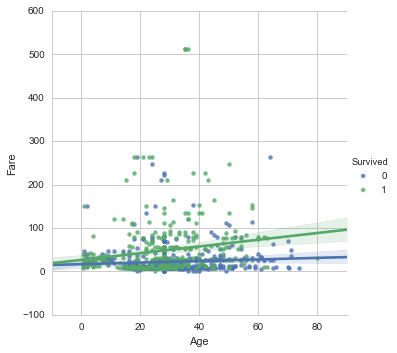

In [465]:
# What other exploratory analysis can you perform?
# Used seaborn to plot age versus fare color coded by survival
sns.lmplot(x='Age',y='Fare', hue='Survived',data=df)

In [466]:
# group by counts by Passenger class 1 through 3
df_by_pclass_unnorm = pd.DataFrame()
df_by_pclass_unnorm[1] = df[df['Pclass']==1]['Survived'].value_counts()
df_by_pclass_unnorm[2] = df[df['Pclass']==2]['Survived'].value_counts()
df_by_pclass_unnorm[3] = df[df['Pclass']==3]['Survived'].value_counts()
# Normalized
df_by_pclass_normed = pd.DataFrame()
df_by_pclass_normed[1] = df[df['Pclass']==1]['Survived'].value_counts(normalize=True)
df_by_pclass_normed[2] = df[df['Pclass']==2]['Survived'].value_counts(normalize=True)
df_by_pclass_normed[3] = df[df['Pclass']==3]['Survived'].value_counts(normalize=True)

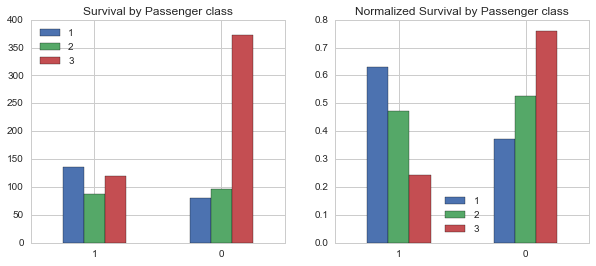

In [467]:
fig1 = plt.figure(figsize=(10,4))
ax1 = fig1.add_subplot(121)
df_by_pclass_unnorm.plot(ax=ax1, kind='bar', rot=0, title="Survival by Passenger class")

ax2 = fig1.add_subplot(122)
df_by_pclass_normed.plot(ax=ax2, kind='bar', rot=0, title="Normalized Survival by Passenger class")

### Check and convert all data types to numerical

In [468]:
# Check data types
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [327]:
df.columns

Index([u'Survived', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Embarked'],
      dtype='object')

### Write a function to pre-process data for building a model

In [469]:
def pre_proc(df):
    '''Create dummy variables for all non-numerical columns'''
   
    # Get dummy variables for Sex and Embarked
    # Remove Sex and Embarked columns
    df = pd.get_dummies(df, columns=['Sex', 'Embarked'])
  
  
    return df

In [470]:
# Apply pre_proc() to DF
df = pre_proc(df)

# Check cleaned data
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


![](../assets/images/workflow/data-science-workflow-06.png)

## Part 4. Build a Model

Create a cross validation split, select and build a model, evaluate the model, and refine the model

### Create cross validation sets

In [471]:
# Set target variable name
target = 'Survived'

# Set X and y
X = df.drop([target], axis=1)
y = df[target]

In [472]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [481]:
# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.4)

In [482]:
y_test[:5]

675    0
683    0
621    1
659    0
780    1
Name: Survived, dtype: int64

### Build a model

In [483]:
# Instantiate logistic regression classifier using default params and Train logistic regression classifier on training set
lm = linear_model.LogisticRegression().fit(X_train, y_train)

In [484]:
lm.coef_

array([[-0.75023083, -0.02922095, -0.32980565, -0.03494749,  0.00780156,
         1.89093701, -0.61122442,  0.49498467,  0.45128663,  0.33344129]])

### Evaluate the model

In [485]:
y_test.mean()

0.3585434173669468

In [486]:
# Check model accuracy on test set
print "Accuracy: %0.3f" % lm.score(X_test, y_test)

Accuracy: 0.798


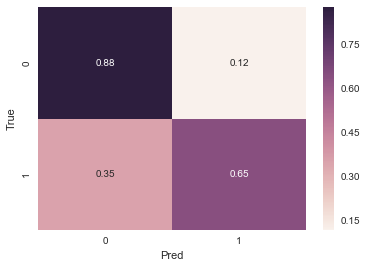

Confusion Matrix:
[[202  27]
 [ 45  83]]


In [487]:
# Get confusion matrix on test set
y_pred = lm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [488]:
zip(X_test.columns, lm.coef_[0])

[('Pclass', -0.75023082842162903),
 ('Age', -0.029220950230317684),
 ('SibSp', -0.32980565265479428),
 ('Parch', -0.034947494067099051),
 ('Fare', 0.0078015602891173454),
 ('Sex_female', 1.8909370108259604),
 ('Sex_male', -0.61122441657913873),
 ('Embarked_C', 0.4949846718907352),
 ('Embarked_Q', 0.45128663387027584),
 ('Embarked_S', 0.33344128848581001)]

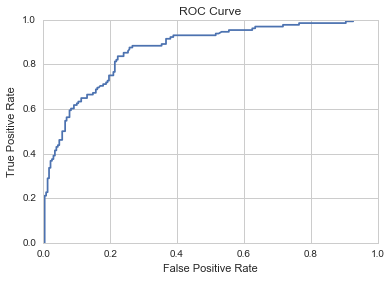

ROC AUC: 0.866


In [489]:
# Plot ROC curve and get AUC score
y_pred_proba = lm.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba)

 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, y_pred_proba)

In [490]:
# What other metrics can you calculate
print metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.82      0.88      0.85       229
          1       0.75      0.65      0.70       128

avg / total       0.80      0.80      0.79       357



### Tune the model

In [491]:
# Set list of values to grid search over
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
s = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
params = {'C': c, 'solver':s}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(estimator=linear_model.LogisticRegression(), param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

Best Params:
{'C': 0.1, 'solver': 'newton-cg'}
Accuracy of current model: 0.798
Accuracy using best param: 0.803


### Update parameters

In [492]:
# Current model params
print lm
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)

# Update model params
lm.set_params(C=0.1)
lm.set_params(solver='newton-cg')

# Retrain model on new params
lm.fit(X_train, y_train)

# Updated model params
print lm
print "Accuracy of updated model: %0.3f" % lm.score(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of current model: 0.798
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of updated model: 0.790


![](../assets/images/workflow/data-science-workflow-07.png)

## Part 5: Present the Results

Generate summary of findings and kaggle submission file.

NOTE: For the purposes of generating summary narratives and kaggle submission, we can train the model on the entire training data provided in _train.csv_.

### Load Kaggle training data and use entire data to train tuned model

In [493]:
# Load data
df_train = pd.read_csv("../assets/datasets/titanic/train.csv")

# Wrangle data
df_train = wrangler(df_train)

# Pre-process data
df_train = pre_proc(df_train)

In [494]:
# Set target variable name
target = 'Survived'

# Set X_train and y_train
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]

In [495]:
# Build tuned model
lm = linear_model.LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

# Train tuned model
lm.fit(X_train, y_train)

# Score tuned model
print "Accuracy: %0.3f" % lm.score(X_train, y_train)

Accuracy: 0.806


### Use trained model to generate a few summary findings

In [496]:
# Generate probabililty of survivial using trained model
df_train['Probability'] = lm.predict_proba(X_train)[:,1]

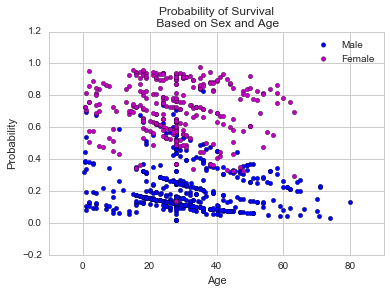

In [497]:
# Plot Probability of Survivial Based on Sex and Age
ax = df_train[df_train['Sex_male']==1].plot(x='Age', y='Probability', kind='scatter', color='b', label='Male')
df_train[df_train['Sex_female']==1].plot(ax=ax, x='Age', y='Probability', kind='scatter', color='m', label='Female')
ax.set(title='Probability of Survival\n Based on Sex and Age')

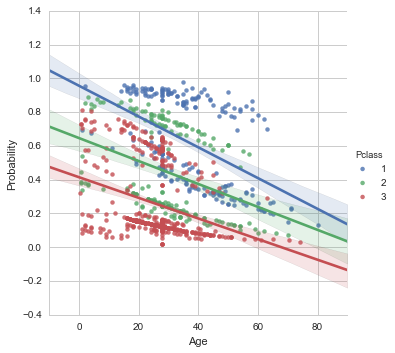

In [498]:
# Plot Probability of Survivial Based on Pclass and Age
sns.lmplot(x="Age", y="Probability", hue="Pclass", data=df_train)

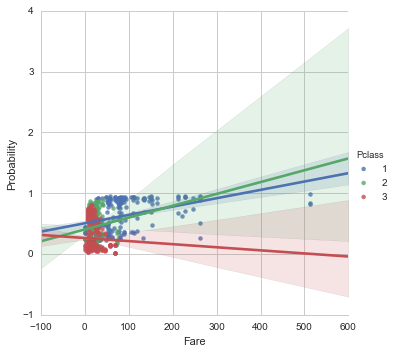

In [499]:
# What other summary visualizations can you make?
sns.lmplot(x='Fare', y='Probability', hue='Pclass', data=df_train)

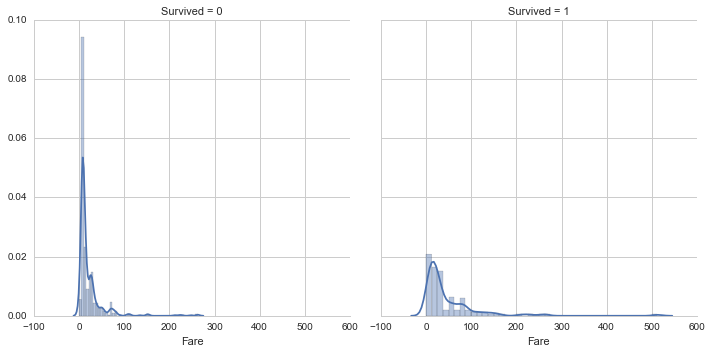

In [500]:
g = sns.FacetGrid(df_train, col='Survived', size=5)
g.map(sns.distplot,'Fare')

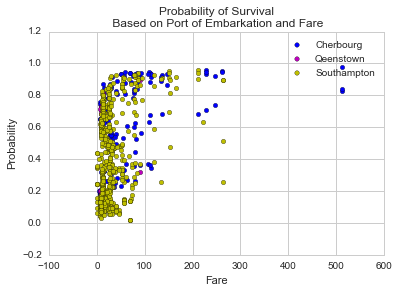

In [501]:
# Plot Probability of Survivial Based on Port of Embarkation and Fare
ax = df_train[df_train['Embarked_C']==1].plot(x='Fare', y='Probability', kind='scatter', color='b', label='Cherbourg')
df_train[df_train['Embarked_Q']==1].plot(ax=ax, x='Fare', y='Probability', kind='scatter', color='m', label='Qeenstown')
df_train[df_train['Embarked_S']==1].plot(ax=ax, x='Fare', y='Probability', kind='scatter', color='y', label='Southampton')
ax.set(title='Probability of Survival\n Based on Port of Embarkation and Fare')

**Summary of findings**: The data science workflow was followed to complete this assignment. Titanic dataset was acquired on the Kaggle website. Raw dataset contained 891 records and 12 columns including the outcome (Survived-1, not Survived-0) and passenger characteristics. After parsing the data and checking for missing values, non-generic columns (i.e.PassengerId, Name, Ticket, Cabin) were dropped. Additionally, missing values in columns Age and Fare were filled with median values while missing values in Embarked column were filled with the first mode. Exploratory analysis helped to recognize any potential associations between variables and the outcome. Most notably, there were differences in survival numbers by gender and passenger class. As a part of data pre-processing, dummies were created for all non-numerical variables (i.e. Sex, Embarked). Although training and testing set were provided, the training set was futher split in order to test and tune the model. Because we are prediciting categorical variable (Survived/Not Survived), logisic regression was used to build the model. Accuracy score of the original model is 0.798 which is higher than if we just predicted all positive outcomes (approx. 65% accuracy). To further tune the model, grid search was applied to identify the best parameters. However, accuracy of the updated model using best parameters did not change (current model - 0.798, updated model -0.790). After training the entire train dataset on the new model, accuracy score was 0.806. When plotting the findings, it appears that there is distict separation in probability of survival by gender. Female passengers had higher probability of survival than male passengers.Alhough there were first class passengers who did not survive, there is a distinct cluster of first class passengers with high probability of survival. Fare paid does not appear to have any significant effect on the survival probability.

### Load Kaggle test data, make predictions using model, and generate submission file

In [502]:
# Load data
df_test = pd.read_csv("../assets/datasets/titanic/test.csv")

# Create DF for submission
df_sub = df_test[['PassengerId']]

# Wrangle data
df_test = wrangler(df_test)

# Pre-process data
df_test = pre_proc(df_test)

# Check data
df_sub.head()

# Predict using tuned model
df_sub['Survived'] = lm.predict(df_test)

# Write submission file
df_sub.to_csv("../assets/datasets/titanic/mysubmission.csv", index=False)

print "Check ../assets/datasets/titanic/ for submission file"

Check ../assets/datasets/titanic/ for submission file


In [503]:
% pwd

u'c:\\Users\\korol_000\\DS\\DS-DC-14\\projects\\unit-projects\\project-4\\starter-code'

**Kaggle score** _(if submitted to Kaggle)_: 0.76555

**HINT**: Try tranforming or combining features and create additional features to improve your score. This is a popular introductory dataset, Google for additional feature engineering hints!